In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rasterio as rio
from rasterio.plot import reshape_as_image
from sklearn.model_selection import train_test_split
import glob,os,sys

training_path = "Input/sentinel/test_data_from_drive/patches_all/train/"
target_file_path = "Input/Target/concat/target_yield.shp"
patch_dim = (256, 256, 13)


In [21]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [4]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='~/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=Fa

In [5]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128), method="nearest")
    input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
    return input_image, input_mask

def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    return input_image, input_mask

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image_train(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [7]:
load_image_train

<function __main__.load_image_train(datapoint)>

In [8]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2023-08-21 12:28:00.327454: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


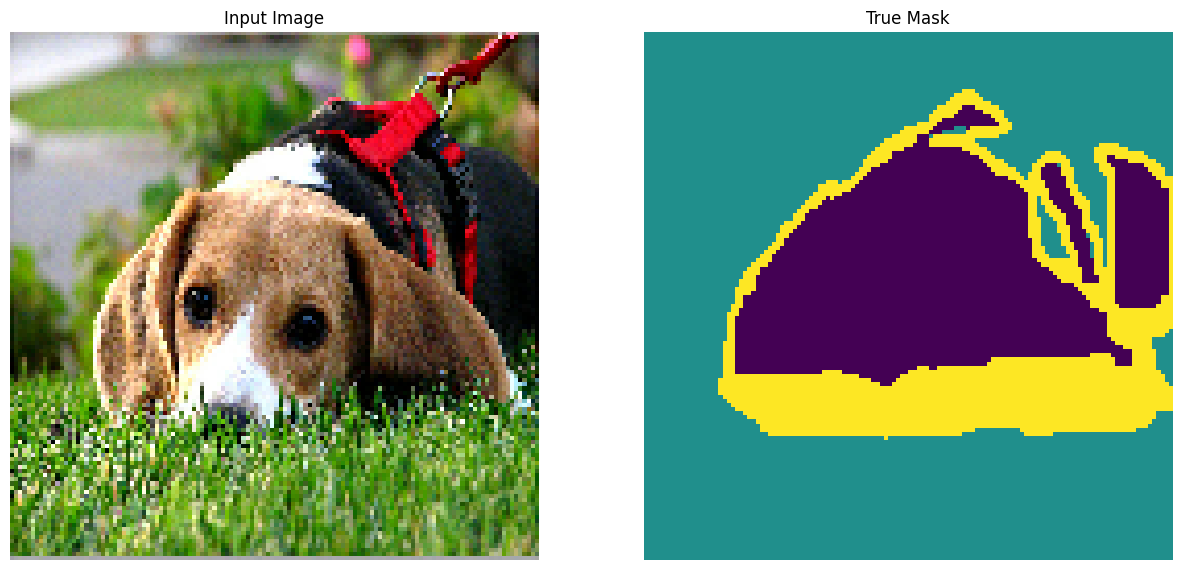

In [10]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [8]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

In [ ]:
def read_training():
    training_file_list = glob.glob(os.path.join(training_path,"*.tif"))
    target_gdf = gpd.read_file(target_file_path)
    print("Total Number of Patches:",len(training_file_list))
    ignore_patch_list = list()
    x = list()
    y = list()
    X_train = list()
    X_test = list()
    y_train = list()
    y_test = list()
    count = 0 
    for file in training_file_list:

        patch_src = rio.open(file)
        f_name = file.split("/")[-1].split(".")[0]
        patch_src_read = reshape_as_image(patch_src.read()) ## Change the index here to add or remove the mask layer
        if patch_src_read.shape != patch_dim:
            ignore_patch_list.append(f_name)
            # print("Patch Dimensions Mismatch, skipping patch : {}".format(f_name))
            continue

        if np.isnan(patch_src_read).any():
            # print("Has Nan values, skipping patch : {}".format(f_name))
            continue

        query = target_gdf.query(f"patch_name == '{f_name}'")["ykg_by_e7"]
        if len(query) != 1:
            # print("patch has no target value, skipping patch : {}".format(f_name))
            continue
        print(patch_src_read[:,:,0:12].shape)
        print(patch_src_read[:,:,12].shape)

        x.append(patch_src_read[:,:,0:12])
        y.append(patch_src_read[:,:,12])
        # y.append(float(query))

        patch_src.close()
        print(count)
        count +=1
        if count > 10:
            break

    # self.y = self.scaler.fit_transform(np.array(self.y).reshape(-1, 1))
    y = np.array(y)
    x = np.array(x)
    print("Any Null values? ",np.isnan(x).any())
    # print(self.y)
    # self.x = np.nan_to_num(self.x, nan=0)# Check for different value for no data
    print(f"x shape :{x.shape}, y shape: {y.shape}")
    # print(np.nanmin(self.x),np.nanmax(self.x))
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
    return X_train, X_test, y_train, y_test
    #Also, split the training into train and val
    # For testing, keep a part of the dataset as seperate (final month)

X_train, X_test, y_train, y_test = read_training()

Total Number of Patches: 22707


In [35]:
y_test.shape

(26,)

In [17]:
X_train.shape

(75, 256, 256, 12)

In [18]:
def build_unet_model():
    # inputs
    inputs = layers.Input(shape=(256,256,12))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model


unet_model = build_unet_model()

2023-09-13 20:36:24.943269: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [19]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [32]:
NUM_EPOCHS = 20
BATCH_SIZE = 64
# TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE
# VAL_SUBSPLITS = 5
# TEST_LENTH = info.splits["test"].num_examples
# VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(X_train, y_train,
                              validation_data = (X_test, y_test),
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH)
                              # validation_steps=VALIDATION_STEPS)

Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 1860, in sparse_categorical_crossentropy
        return backend.sparse_categorical_crossentropy(
    File "/usr/local/lib/python3.8/dist-packages/keras/backend.py", line 5238, in sparse_categorical_crossentropy
        res = tf.nn.sparse_softmax_cross_entropy_with_logits(

    ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(75,) and logits.shape=(4915200, 1)
